In [1]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

import keras 
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense 

from keras.layers import Dropout

from keras.layers import LSTM

from keras.layers import *


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping


from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D



from keras.layers import Dense, Embedding, LSTM, Bidirectional

from tcn import TCN, tcn_full_summary

DATA

In [3]:
df=pd.read_csv("AMZN.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1, 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 60, 1, 1)

TCN Model

In [4]:
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1)


In [5]:
np.random.seed(1)
model = Sequential()
model.add(TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0.1, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 4s 11ms/step - loss: 5.1691
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.1663
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0960
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0597
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0487
Epoch 6/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0405
Epoch 7/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0329
Epoch 8/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0246
Epoch 9/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0237
Epoch 10/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0251
Epoch 11/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 12/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0159
Epoch 13/50
31/31 [==================

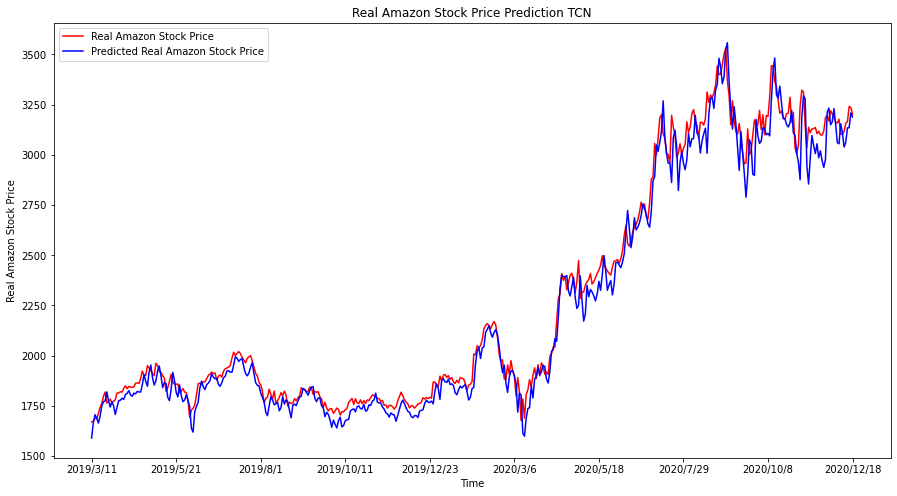

In [6]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Real Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Real Amazon Stock Price Prediction TCN')
plt.xlabel('Time')
plt.ylabel('Real Amazon Stock Price')
plt.legend() 
plt.savefig("Real Amazon TCN")
plt.show()

In [7]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

56.50854516163734

In [9]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

76.95272432210695

TCN + GRU model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 gru (GRU)                      (None, 200)          121800      ['input_1[0][0]']                
                                                                                                  
 tcn_1 (TCN)                    (None, 64)           185408      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            201         ['gru[0][0]']                    
                                                                                              

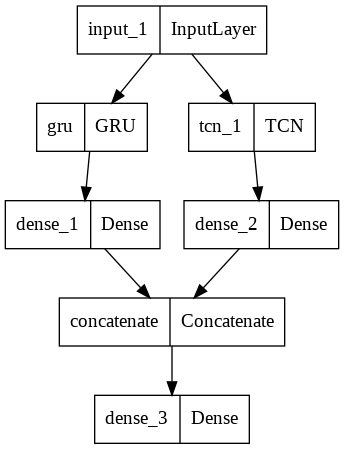

In [10]:
np.random.seed(1)


from keras.layers import Input
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.models import Model

visible = Input(shape=(60,1))

#GRU
gru1 = GRU(units = 200, input_shape = (X_train.shape[1], 1))(visible)
out1 = Dense(units = 1)(gru1)

#TCN
tcn1 = TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1))(visible)
out2 = Dense(units = 1)(tcn1)

# merge interpretation
merge = concatenate([out1, out2])

# output
output = Dense(1)(merge)
model = Model(inputs=visible, outputs=output)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='shared_feature_extractor.png')

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 13ms/step - loss: 0.5391
Epoch 2/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 3/30
31/31 [==============================] - 0s 12ms/step - loss: 5.4367e-04
Epoch 4/30
31/31 [==============================] - 0s 11ms/step - loss: 4.6361e-04
Epoch 5/30
31/31 [==============================] - 0s 10ms/step - loss: 6.1191e-04
Epoch 6/30
31/31 [==============================] - 0s 11ms/step - loss: 6.4689e-04
Epoch 7/30
31/31 [==============================] - 0s 10ms/step - loss: 5.8632e-04
Epoch 8/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 9/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 10/30
31/31 [==============================] - 0s 10ms/step - loss: 5.2437e-04
Epoch 11/30
31/31 [==============================] - 0s 10ms/step - loss: 3.5826e-04
Epoch 12/30
31/31 [==============================] - 0s 11ms/step - loss: 3.0557e-04
Epoch

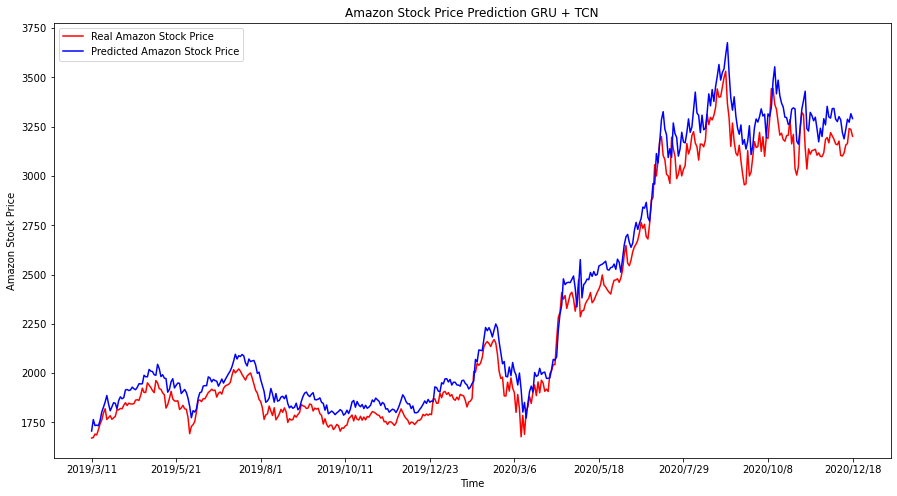

In [12]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction GRU + TCN')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.savefig("Amazon GRU + TCN")
plt.show() 

In [13]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse, rmse)

86.11179694269677 100.7843790965795


CNN LSTM MODEL

In [14]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1, 1)


In [15]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape = (X_train.shape[1],1, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))

model.add(TimeDistributed(Flatten()))

model.add(GRU(units = 700)) #, return_sequences = True

model.add(Dropout(0.1))


model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 2s 16ms/step - loss: 0.0157
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 6.4051e-04
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 2.9307e-04
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 3.2050e-04
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 3.0779e-04
Epoch 6/50
31/31 [==============================] - 0s 14ms/step - loss: 2.6918e-04
Epoch 7/50
31/31 [==============================] - 0s 13ms/step - loss: 3.1300e-04
Epoch 8/50
31/31 [==============================] - 0s 14ms/step - loss: 2.7686e-04
Epoch 9/50
31/31 [==============================] - 0s 14ms/step - loss: 2.7121e-04
Epoch 10/50
31/31 [==============================] - 0s 14ms/step - loss: 2.8531e-04
Epoch 11/50
31/31 [==============================] - 0s 14ms/step - loss: 2.8582e-04
Epoch 12/50
31/31 [==============================] - 0s 14ms/step - loss: 2.92

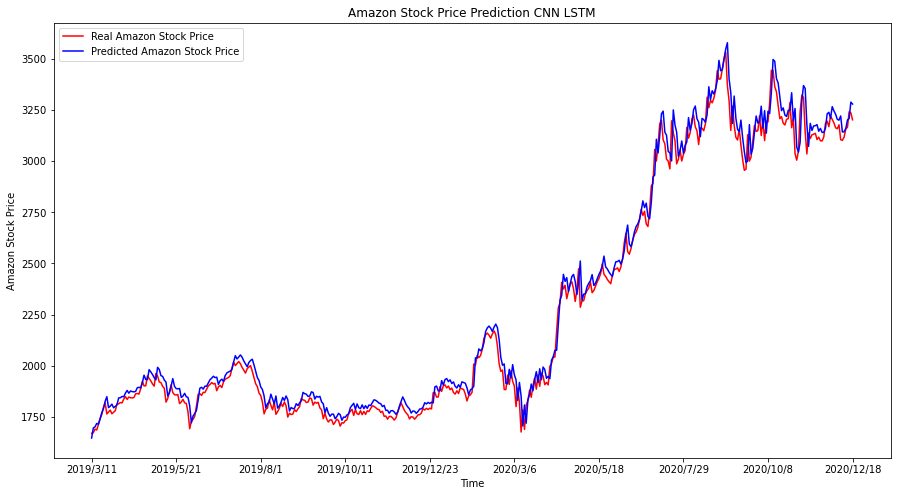

In [16]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction CNN LSTM')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend() 
plt.savefig("Amazon CNN LSTM")
plt.show()

In [17]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

44.17361838011017

In [18]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

58.62546738258032

CNN

In [19]:
df=pd.read_csv("AMZN.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 1, 60, 1)

In [20]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=128, kernel_size=11, activation='relu'), input_shape = (1, X_train.shape[2],1)))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
print(model.output_shape)
model.add(TimeDistributed(Flatten()))
print(model.output_shape)


model.add(Dense(units = 1))
print(model.output_shape)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

(None, 1, 50, 128)
(None, 1, 25, 128)
(None, 1, 3200)
(None, 1, 1)
Epoch 1/30
31/31 [==============================] - 0s 2ms/step - loss: 0.1195
Epoch 2/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0717
Epoch 3/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0696
Epoch 4/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0684
Epoch 5/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 6/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 7/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0692
Epoch 8/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0686
Epoch 9/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0686
Epoch 10/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0680
Epoch 11/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0687
Epoch 12/30
31/31 [==============================] - 0s 2ms/st

In [21]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1],1))
print(X_test.shape)
# (459, 60, 1)

(511, 1)
(451, 1, 60, 1)


In [22]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(451,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

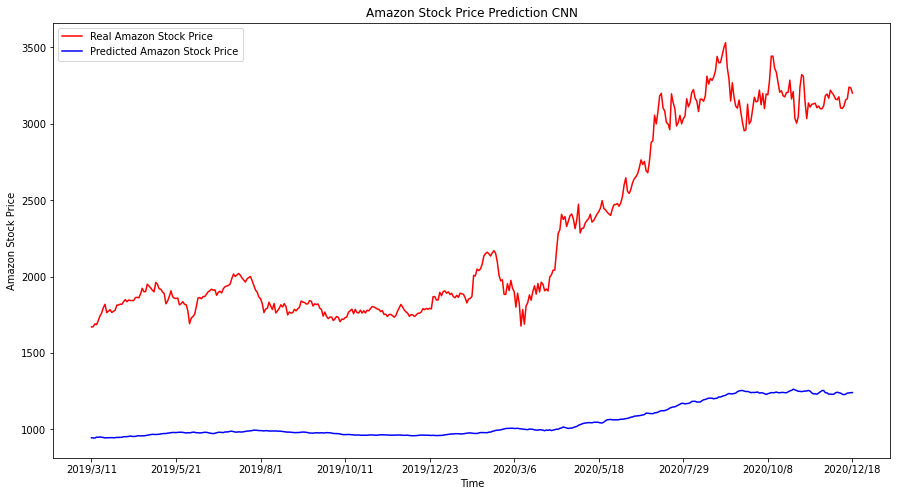

In [23]:

predicted_stock_price = model.predict(X_test).reshape(-1,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction CNN')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.savefig("Amazon CNN")
plt.show() 

In [24]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

1230.75021434278

In [25]:
rmse=math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

1321.01555735683

LSTM GRU MODEL

In [26]:

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(992, 60, 1)

In [27]:
np.random.seed(1)
model = Sequential()
model.add(LSTM(units = 700, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(GRU(units = 700,  input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 32ms/step - loss: 0.0078
Epoch 2/30
31/31 [==============================] - 1s 31ms/step - loss: 8.9583e-04
Epoch 3/30
31/31 [==============================] - 1s 31ms/step - loss: 5.2359e-04
Epoch 4/30
31/31 [==============================] - 1s 31ms/step - loss: 6.8664e-04
Epoch 5/30
31/31 [==============================] - 1s 31ms/step - loss: 5.3526e-04
Epoch 6/30
31/31 [==============================] - 1s 31ms/step - loss: 6.6939e-04
Epoch 7/30
31/31 [==============================] - 1s 31ms/step - loss: 7.8208e-04
Epoch 8/30
31/31 [==============================] - 1s 31ms/step - loss: 4.5854e-04
Epoch 9/30
31/31 [==============================] - 1s 31ms/step - loss: 7.5899e-04
Epoch 10/30
31/31 [==============================] - 1s 31ms/step - loss: 3.6557e-04
Epoch 11/30
31/31 [==============================] - 1s 31ms/step - loss: 5.5664e-04
Epoch 12/30
31/31 [==============================] - 1s 31ms/step - loss: 5.56

TEST DATA

In [28]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(511, 1)
(451, 60, 1)


PREDICTION

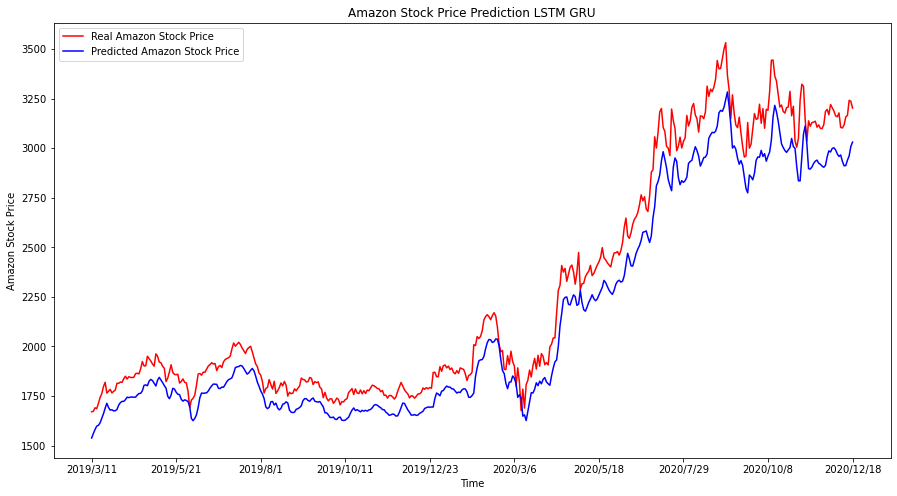

In [29]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction LSTM GRU')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend() 
plt.savefig("Amazon LSTM GRU")
plt.show()

In [30]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

137.55729561675446

In [31]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

153.31705113265534

LSTM Model

In [32]:
model = Sequential()

model.add(LSTM(units = 700, input_shape = (X_train.shape[1], 1))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 17ms/step - loss: 0.0558
Epoch 2/30
31/31 [==============================] - 0s 15ms/step - loss: 0.0020
Epoch 3/30
31/31 [==============================] - 0s 15ms/step - loss: 6.6139e-04
Epoch 4/30
31/31 [==============================] - 0s 15ms/step - loss: 7.3124e-04
Epoch 5/30
31/31 [==============================] - 0s 15ms/step - loss: 7.0538e-04
Epoch 6/30
31/31 [==============================] - 0s 15ms/step - loss: 7.0947e-04
Epoch 7/30
31/31 [==============================] - 0s 15ms/step - loss: 6.2312e-04
Epoch 8/30
31/31 [==============================] - 0s 15ms/step - loss: 6.3658e-04
Epoch 9/30
31/31 [==============================] - 0s 15ms/step - loss: 6.8781e-04
Epoch 10/30
31/31 [==============================] - 0s 15ms/step - loss: 7.9650e-04
Epoch 11/30
31/31 [==============================] - 0s 15ms/step - loss: 9.0282e-04
Epoch 12/30
31/31 [==============================] - 0s 14ms/step - loss: 5.8127e-

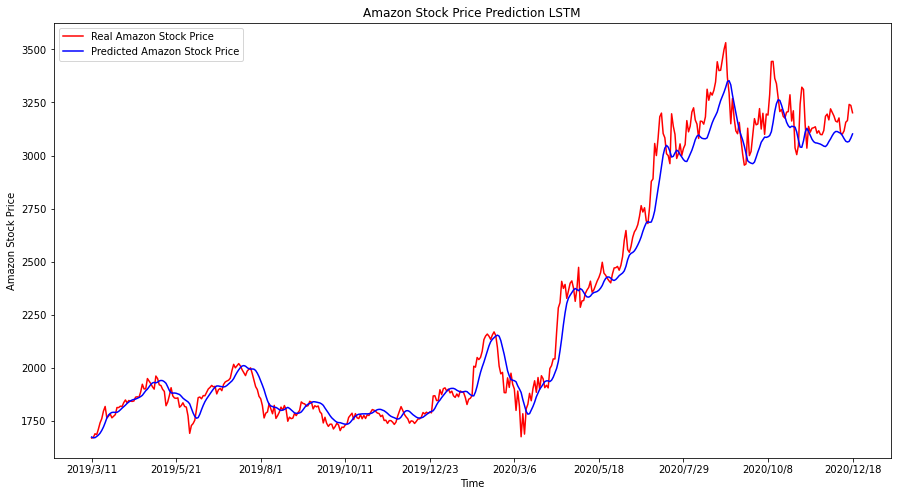

In [33]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction LSTM')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend() 
plt.savefig("Amazon LSTM")
plt.show()

In [34]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

59.42312522091533

In [35]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

84.88161698379822

RNN MODEL


In [36]:
model = Sequential()

model.add(SimpleRNN(units = 700, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32) 

Epoch 1/30
31/31 [==============================] - 2s 38ms/step - loss: 3.2516
Epoch 2/30
31/31 [==============================] - 1s 36ms/step - loss: 0.7175
Epoch 3/30
31/31 [==============================] - 1s 36ms/step - loss: 0.6240
Epoch 4/30
31/31 [==============================] - 1s 36ms/step - loss: 0.4222
Epoch 5/30
31/31 [==============================] - 1s 37ms/step - loss: 0.4151
Epoch 6/30
31/31 [==============================] - 1s 37ms/step - loss: 0.4034
Epoch 7/30
31/31 [==============================] - 1s 36ms/step - loss: 0.3602
Epoch 8/30
31/31 [==============================] - 1s 37ms/step - loss: 0.3670
Epoch 9/30
31/31 [==============================] - 1s 36ms/step - loss: 0.3322
Epoch 10/30
31/31 [==============================] - 1s 37ms/step - loss: 0.3282
Epoch 11/30
31/31 [==============================] - 1s 37ms/step - loss: 0.2818
Epoch 12/30
31/31 [==============================] - 1s 37ms/step - loss: 0.3015
Epoch 13/30
31/31 [==================

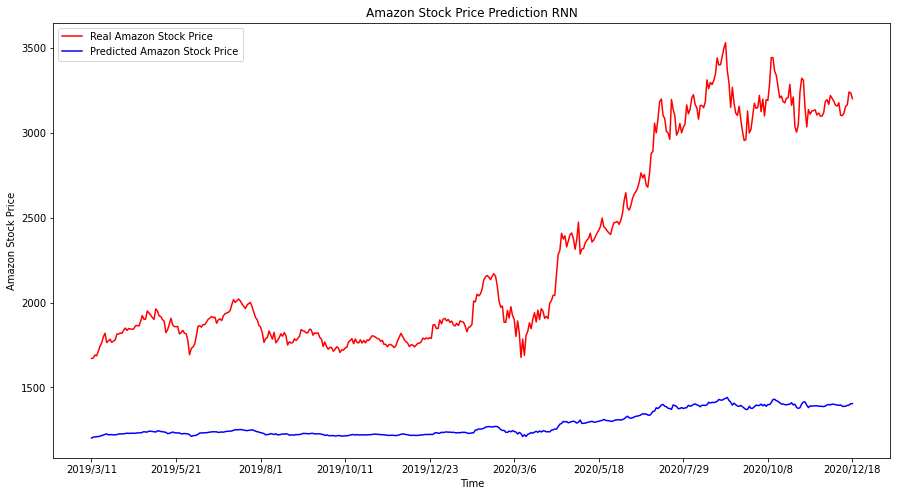

In [37]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction RNN')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend() 
plt.savefig("Amazon RNN")
plt.show()

In [38]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

995.0565269207316

In [39]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

1117.6699473037986

GRU

In [40]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 15ms/step - loss: 0.0199
Epoch 2/30
31/31 [==============================] - 0s 12ms/step - loss: 7.6346e-04
Epoch 3/30
31/31 [==============================] - 0s 12ms/step - loss: 4.5862e-04
Epoch 4/30
31/31 [==============================] - 0s 12ms/step - loss: 4.8305e-04
Epoch 5/30
31/31 [==============================] - 0s 12ms/step - loss: 4.6758e-04
Epoch 6/30
31/31 [==============================] - 0s 12ms/step - loss: 4.8063e-04
Epoch 7/30
31/31 [==============================] - 0s 12ms/step - loss: 4.1512e-04
Epoch 8/30
31/31 [==============================] - 0s 12ms/step - loss: 5.1904e-04
Epoch 9/30
31/31 [==============================] - 0s 12ms/step - loss: 4.5649e-04
Epoch 10/30
31/31 [==============================] - 0s 12ms/step - loss: 4.5645e-04
Epoch 11/30
31/31 [==============================] - 0s 12ms/step - loss: 4.6293e-04
Epoch 12/30
31/31 [==============================] - 0s 12ms/step - loss: 4.71

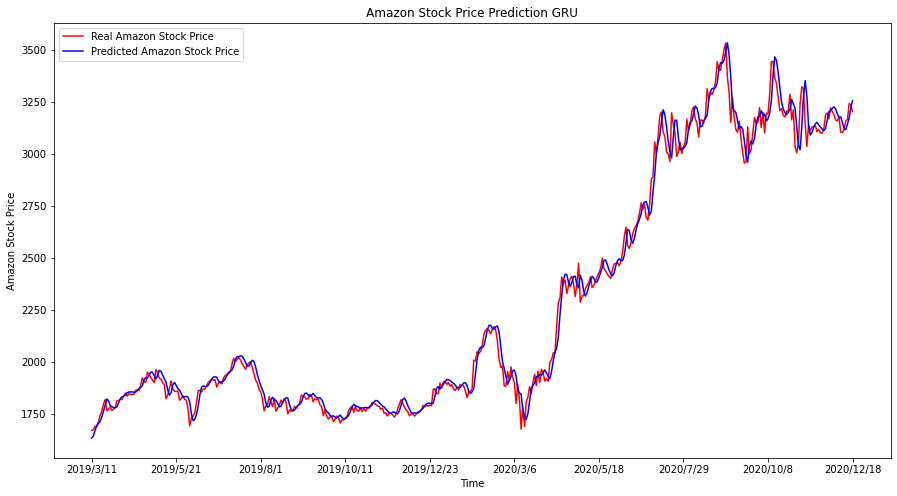

In [41]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction GRU')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.savefig("Amazon GRU")
plt.show() 

In [42]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

38.34983078170039

In [43]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

56.02941284323731

Bi-LSTM

In [44]:
np.random.seed(1)
model = Sequential()

model.add(Bidirectional(LSTM(units = 700, input_shape = (X_train.shape[1], 1)))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 4s 31ms/step - loss: 0.0296
Epoch 2/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0020
Epoch 3/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0015
Epoch 4/30
31/31 [==============================] - 1s 30ms/step - loss: 0.0013
Epoch 5/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0011
Epoch 6/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0010
Epoch 7/30
31/31 [==============================] - 1s 29ms/step - loss: 9.2661e-04
Epoch 8/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0011
Epoch 9/30
31/31 [==============================] - 1s 30ms/step - loss: 9.0860e-04
Epoch 10/30
31/31 [==============================] - 1s 30ms/step - loss: 9.6379e-04
Epoch 11/30
31/31 [==============================] - 1s 30ms/step - loss: 8.0718e-04
Epoch 12/30
31/31 [==============================] - 1s 36ms/step - loss: 6.9613e-04
Epoch 13/30
31/31

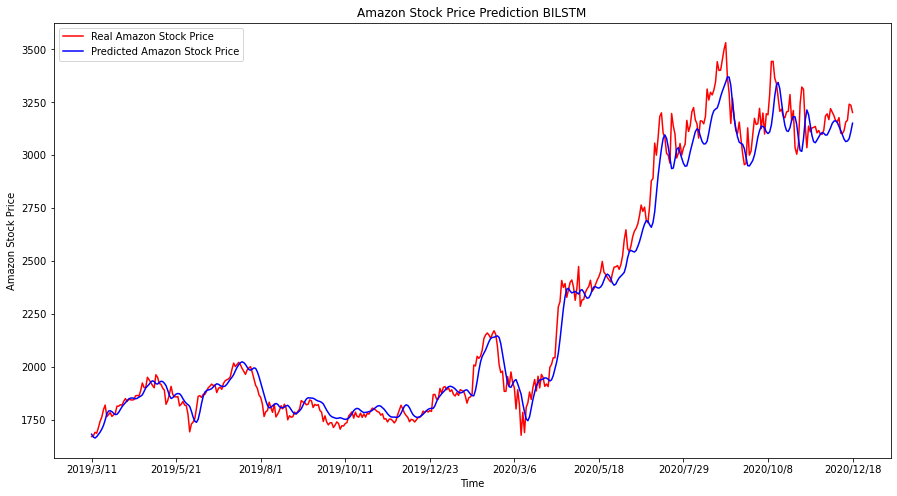

In [45]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction BILSTM')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend() 
plt.savefig("Amazon BILSTM")
plt.show()

In [46]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

54.01295677577605

In [47]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

78.18541308162035

Bi-GRU

In [48]:
model = Sequential()

model.add(Bidirectional(GRU(units = 700, input_shape = (X_train.shape[1], 1))))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 4s 25ms/step - loss: 0.0135
Epoch 2/30
31/31 [==============================] - 1s 23ms/step - loss: 0.0017
Epoch 3/30
31/31 [==============================] - 1s 23ms/step - loss: 0.0012
Epoch 4/30
31/31 [==============================] - 1s 23ms/step - loss: 7.8636e-04
Epoch 5/30
31/31 [==============================] - 1s 23ms/step - loss: 6.2953e-04
Epoch 6/30
31/31 [==============================] - 1s 23ms/step - loss: 5.2518e-04
Epoch 7/30
31/31 [==============================] - 1s 23ms/step - loss: 4.8824e-04
Epoch 8/30
31/31 [==============================] - 1s 23ms/step - loss: 4.6185e-04
Epoch 9/30
31/31 [==============================] - 1s 23ms/step - loss: 4.6988e-04
Epoch 10/30
31/31 [==============================] - 1s 23ms/step - loss: 5.6318e-04
Epoch 11/30
31/31 [==============================] - 1s 23ms/step - loss: 4.0279e-04
Epoch 12/30
31/31 [==============================] - 1s 23ms/step - loss: 5.0294e-04
E

<function matplotlib.pyplot.show>

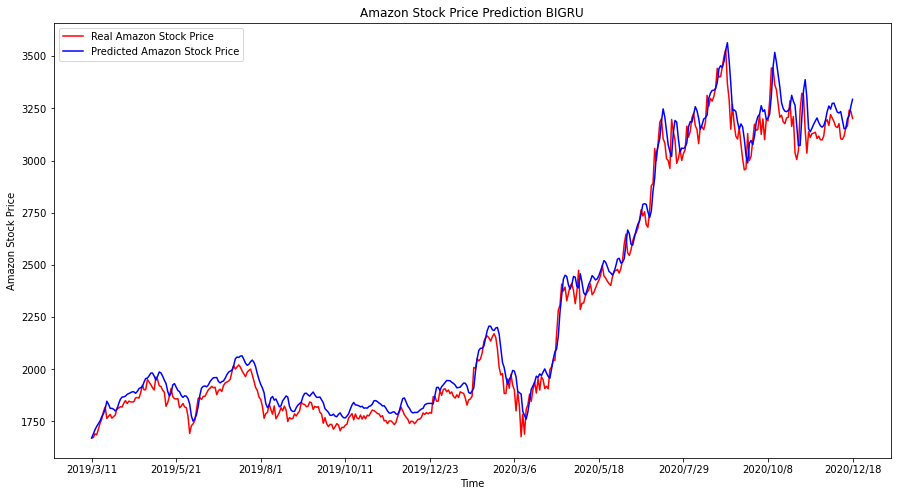

In [49]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Amazon Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction BIGRU')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend() 
plt.savefig("Amazon BIGRU")
plt.show

In [50]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

54.637537809416564

In [51]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

68.70042481375027

Breaking Dataset to Improve Performance

In [52]:
training_set = df.iloc[:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output




In [53]:
X_train = []
y_train = []
for i in range(60, 351):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(501, 852):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(1002, 1353):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(993, 60, 1)

In [54]:

inputs = df.iloc[:, 4:5].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)




(1503, 1)


In [55]:
X_test = []
y_test = []
for i in range(351, 501):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(852, 1002):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(1353, 1503):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(450, 60, 1)


In [56]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
32/32 [==============================] - 2s 15ms/step - loss: 0.0061
Epoch 2/30
32/32 [==============================] - 0s 12ms/step - loss: 2.8545e-04
Epoch 3/30
32/32 [==============================] - 0s 12ms/step - loss: 1.9269e-04
Epoch 4/30
32/32 [==============================] - 0s 12ms/step - loss: 2.0829e-04
Epoch 5/30
32/32 [==============================] - 0s 12ms/step - loss: 1.8778e-04
Epoch 6/30
32/32 [==============================] - 0s 12ms/step - loss: 1.9321e-04
Epoch 7/30
32/32 [==============================] - 0s 12ms/step - loss: 1.6808e-04
Epoch 8/30
32/32 [==============================] - 0s 12ms/step - loss: 1.7793e-04
Epoch 9/30
32/32 [==============================] - 0s 12ms/step - loss: 1.5390e-04
Epoch 10/30
32/32 [==============================] - 0s 12ms/step - loss: 1.8702e-04
Epoch 11/30
32/32 [==============================] - 0s 12ms/step - loss: 1.8717e-04
Epoch 12/30
32/32 [==============================] - 0s 12ms/step - loss: 1.64

In [57]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [58]:
abse = mean_absolute_error(predicted_stock_price, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


In [59]:
abse

76.73573090657987

In [60]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y_test))
rmse

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


96.02009412212676

In [61]:
x1 = df.loc[351:500 , "Date"]
x2 = df.loc[852:1001 , "Date"]
x3 = df.loc[1353: , "Date"]

In [62]:
x = pd.concat([x1,x2,x3], axis =0)

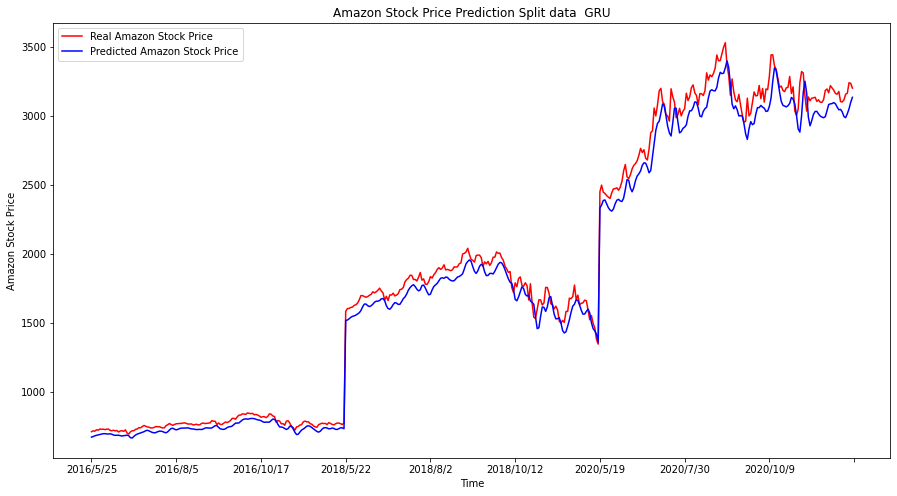

In [63]:

# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y_test, c= "red", label = "Real Amazon Stock Price")
plt.plot(x,predicted_stock_price, color = "blue", label = "Predicted Amazon Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Amazon Stock Price Prediction Split data  GRU')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.savefig("Amazon Split data GRU")
plt.show() 